<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Jerry Sun, Peter Wu, Shihao Cao (js2746, plw53, sfc72)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

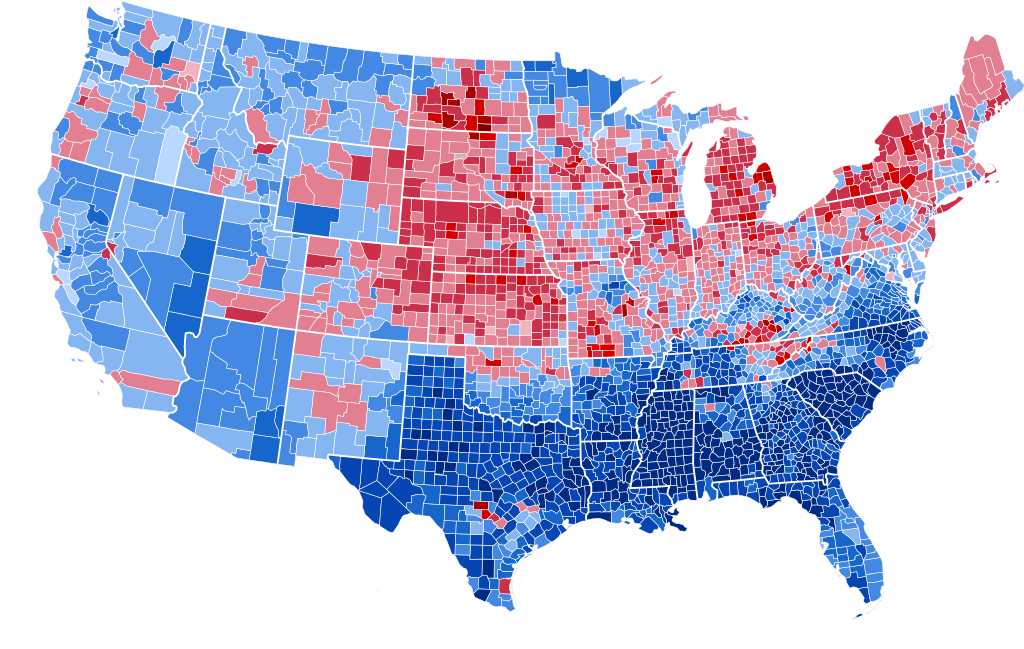

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Split train and validation sets of the train data
from sklearn.neighbors import KNeighborsClassifier # Import KNN model for first basic solution
from sklearn import svm # Import SVM since it's good at predicting binary labels - second basic solution
from sklearn.model_selection import cross_val_score # uses K-fold cross-val by default.
from sklearn.metrics import make_scorer # Import scorer for use in cross-validation scoring (weighted accuracy)
import warnings # Remove Warning print statements
warnings.filterwarnings('ignore') # Ignore 

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [2]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    
    d_err = num_pos - num_pos_correct
    r_err = num_neg - num_neg_correct
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. Here is SVM, 
Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [3]:
# Preprocessing any train dataframe (2016/2012 train)
def preprocess(df):    
    '''Preprocesses the training data  
    Args: 
     df: input dataframe
    Returns: 
      df with a Winner indicator column and normalized feature columns
    '''
    # Binary Indicator of Dem or Gop winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0
   
    # Max normalization - Divide by the largest absolute valued feature value
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(np.abs(df[col]))
        df[col] = df[col]/factor
    return df

# Preprocessing any test dataframe (2016/2012 test)
def test_preprocess(df):
    '''Preprocesses the training data  
    Args: 
     df: input dataframe
    Returns: 
      df with normalized feature columns
    '''
    # Max normalization - Divide by the largest absolute valued feature value
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(np.abs(df[col]))
        df[col] = df[col]/factor
    return df

# Package a list of predictions for submission
def package(preds, df):
    '''Packages the predictions for submission using the sample data frame
    Args: 
     preds: input list of predictions
     df: sample dataframe
    Returns: 
      df with predictions substituted in for sample predictions
    '''
    df['Result'][0:] = preds.astype(int)
    return df

In [4]:
# Preprocess training 2016 dataset (keep original intact and unchanged)
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = preprocess(rawdf16.copy())
df16


,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,Winner
0,18019,"Clark County, IN",18791,30012,0.385093,0.094595,0.439863,0.384615,0.280161,0.174274,0
1,6035,"Lassen County, CA",2026,6533,0.369908,-0.355212,0.316151,0.220280,0.160858,0.286307,0
2,40081,"Lincoln County, OK",2423,10838,0.333663,-0.025097,0.391753,0.409091,0.202413,0.219917,0
3,31153,"Sarpy County, NE",27704,44649,0.552519,0.177606,0.487973,0.174825,0.537534,0.120332,0
4,28055,"Issaquena County, MS",395,298,0.200261,-0.247104,0.336770,0.185315,0.089812,0.580913,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",8717,18668,0.343395,-0.067568,0.384880,0.377622,0.256032,0.248963,0
1551,55031,"Douglas County, WI",11342,9657,0.373972,-0.050193,0.336770,0.356643,0.321716,0.215768,1
1552,27065,"Kanabec County, MN",2327,5230,0.381453,0.030888,0.347079,0.363636,0.195710,0.269710,0
1553,17139,"Moultrie County, IL",1476,4453,0.426769,-0.177606,0.443299,0.454545,0.261394,0.190871,0


In [5]:
# Preprocess training 2012 dataset (keep original intact and unchanged)
rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = preprocess(rawdf12.copy())
df12

,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,Winner
0,18019,"Clark County, IN",20775,25422,0.413372,0.000832,0.458042,0.431111,0.273611,0.284672,0
1,6035,"Lassen County, CA",3044,7261,0.399213,-0.164725,0.314685,0.355556,0.179167,0.456204,0
2,40081,"Lincoln County, OK",3265,9542,0.371206,-0.023295,0.395105,0.493333,0.181944,0.182482,0
3,31153,"Sarpy County, NE",24709,40318,0.572738,0.066556,0.555944,0.217778,0.508333,0.142336,0
4,28055,"Issaquena County, MS",479,302,0.242874,0.018303,0.300699,0.320000,0.108333,0.642336,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",11695,15406,0.360048,-0.062396,0.409091,0.448889,0.250000,0.339416,0
1551,55031,"Douglas County, WI",14855,7698,0.366363,-0.054077,0.384615,0.404444,0.304167,0.251825,1
1552,27065,"Kanabec County, MN",3586,4319,0.371879,-0.122296,0.248252,0.364444,0.186111,0.328467,0
1553,17139,"Moultrie County, IL",2142,3781,0.427624,0.006656,0.430070,0.528889,0.215278,0.259124,0


In [6]:
# Read in graph data
dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')
dfgraph

,SRC,DST
0,1001,1001
1,1001,1021
2,1001,1047
3,1001,1051
4,1001,1085
...,...,...
12712,72153,72153
12713,78010,78010
12714,78020,78020
12715,78020,78030


In [7]:
# Read in Sample dataframe
dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')
dfsample

,FIPS,Result
0,17059,0
1,6103,0
2,42047,0
3,47147,0
4,39039,0
...,...,...
1550,55095,0
1551,34035,0
1552,42107,0
1553,48293,0


In [8]:
# Preprocess testing 2016 dataset (keep original intact and unchanged)
rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16.copy())
test16

,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,17059,"Gallatin County, IL",0.335782,-0.050548,0.378947,0.363372,0.126115,0.381910
1,6103,"Tehama County, CA",0.343839,0.008584,0.449123,0.302326,0.197452,0.356784
2,42047,"Elk County, PA",0.417452,-0.044349,0.340351,0.377907,0.236943,0.276382
3,47147,"Robertson County, TN",0.495506,0.035289,0.445614,0.281977,0.236943,0.206030
4,39039,"Defiance County, OH",0.442326,-0.025274,0.389474,0.296512,0.212739,0.246231
...,...,...,...,...,...,...,...,...
1550,55095,"Polk County, WI",0.454619,0.006676,0.333333,0.313953,0.259873,0.231156
1551,34035,"Somerset County, NJ",0.886754,-0.009061,0.354386,0.209302,0.694268,0.206030
1552,42107,"Schuylkill County, PA",0.426136,-0.000477,0.326316,0.389535,0.206369,0.311558
1553,48293,"Limestone County, TX",0.333647,0.002384,0.463158,0.328488,0.178344,0.281407


In [9]:
# Preprocess testing 2012 dataset (keep original intact and unchanged)
rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12.copy())
test12

,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,17059,"Gallatin County, IL",0.314441,-0.128660,0.299003,0.570796,0.142477,0.351464
1,6103,"Tehama County, CA",0.318161,-0.031056,0.378738,0.420354,0.187750,0.573222
2,42047,"Elk County, PA",0.401674,-0.026619,0.322259,0.548673,0.205060,0.292887
3,47147,"Robertson County, TN",0.445897,-0.039929,0.475083,0.415929,0.225033,0.292887
4,39039,"Defiance County, OH",0.382532,-0.057675,0.385382,0.433628,0.217044,0.322176
...,...,...,...,...,...,...,...,...
1550,55095,"Polk County, WI",0.412586,-0.099379,0.318937,0.371681,0.255659,0.334728
1551,34035,"Somerset County, NJ",0.788239,0.000000,0.345515,0.300885,0.692410,0.309623
1552,42107,"Schuylkill County, PA",0.366433,0.007098,0.328904,0.584071,0.198402,0.405858
1553,48293,"Limestone County, TX",0.300998,0.011535,0.451827,0.469027,0.181092,0.288703


<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [10]:
# Basic Model 1 - K-Nearest Neighbors

def knn_classifier(k_grid, distance_metrics, train_x, train_y):
    '''Returns KNN parameters for classifying county election results.

    Args: 
      k_grid: interval for grid searching number of neighbors
      distance_metrics: array of distance metric strings for the K-nearest neighbor classifier
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, 0, 'euclidean']
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    
    # Grid search the hyperparameters
    for metric in distance_metrics:
        for k in k_grid:
            knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            # 10-Fold Cross validation via Sklearn
            scores = cross_val_score(knn_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                    best[0], best[1], best[2] = np.mean(scores), k, metric
    return best


In [11]:
# Basic Model 2 - SVM. 
def train_SVM(c_grid, g_grid, train_x, train_y):
    '''Trains an SVM using scikit-learn by conducting a grid search and cross-validation
       to find optimal hyperparameter values based on given intervals.
       
    Args: 
      c_grid: interval for grid searching C values
      g_grid: interval for grid searching gamma values
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, -1, -1]
    # Grid search the hyperparameters
    for c in c_grid:
        for g in g_grid:
            # We suspect the data to be nonlinear and RBF is a consistent choice for this purpose.
            svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
            # 10-Fold Cross validation via Sklearn
            scores = cross_val_score(svm_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                best[0], best[1], best[2] = np.mean(scores), c, g
    return best

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [12]:
# Partition data into train for features and labels, and test labels for predictions
train_x = np.array(df16.iloc[0:,4:10])
train_y = np.array(df16.iloc[0:,10])
test_x = np.array(test16.iloc[0:,2:])

In [13]:
# K-Nearest Neighbors algorithm

# Grid search using these grids in the KNN model. For use with cross-validation.
ks = range(1, 6, 1)
distance_metrics = ['minkowski', 'manhattan', 'chebyshev', 'euclidean', 'seuclidean']

# Cross-validate on hyperparameters for model selection
best = knn_classifier(ks, distance_metrics, train_x, train_y)

print(best)
knn_model = KNeighborsClassifier(n_neighbors=best[1], metric=best[2])
knn_model.fit(train_x, train_y)
preds_knn = knn_model.predict(test_x)

[0.8294589416858154, 2, 'minkowski']


In [14]:
# SVM algorithm with 10-fold cross validation + grid search to find good hyperparameters.

# Grid search using these intervals for C and gamma in the SVM model. For use with cross-validation.
cs = (2.0**np.linspace(5,11,10))
gammas = (np.linspace(0.5,7,10))

# Cross-validate on hyperparameters for model selection
best = train_SVM(cs, gammas, train_x, train_y)

print(best)
svm_model = svm.SVC(kernel='rbf', C=best[1], gamma=best[2])
svm_model.fit(train_x, train_y)
preds_svm = svm_model.predict(test_x)

[0.8541057735917128, 128.0, 2.6666666666666665]


In [15]:
# Package predictions for both basic models into a csv for submission

submission_knn = package(preds_knn, dfsample.copy())
submission_svm = package(preds_svm, dfsample.copy())

submission_knn.to_csv('submission_knn.csv',index = False)
submission_svm.to_csv('submission_svm.csv',index = False)


# Check number of DEM and GOP counties predicted for further validation information
submiss_knn = pd.read_csv('submission_knn.csv', sep=',', encoding='unicode_escape')
series_knn = submiss_knn['Result'].value_counts()
submiss_svm = pd.read_csv('submission_svm.csv', sep=',', encoding='unicode_escape')
series_svm = submiss_svm['Result'].value_counts()

print(series_knn) 
print(series_svm)

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features?

Normalization:

- We tried min/max as well as standardization normalization techniques but neither worked as well as just normal Max normalization when we fed the data into our basic models (SVM, KNN). This could be due to information loss with some feature columns having negative values prior to normalization that no longer have negative values post normalization.


2.4.2 Which two learning methods from class did you choose and why did you made the choices?

We chose the K-Nearest Neighbors and Support Vector Machines learning methods. 

We first used **K-Nearest Neighbors** due to its simplicity and ease of use for empirical risk minimization, as well as the fact that we expect data points in the test set with similar features to have similar labels. Due to the KNN algorithm, it inherently assigns the same label to features with respect to its k neighbors according to some distance metric. The dataset is also relatively small, so the algorithm will not be bogged down by too much inefficiency. Also, the feature dimensionality is not so large, so the algorithm will not suffer from the “curse of dimensionality”.

We also used the **SVM**, specifically with the Radial Basis Function (RBF) kernel as our second basic model, because we expect our data to be nonlinearly separable, and a simple linear classifier would just not cut it. The RBF kernel is specifically used as it relates close points to likely have the same label, with a similar rationale to the use of KNN. By using a kernel to find a hyperplane within this kernel space to separate the data into classes, we can cross validate if needed on the SVM’s hyperparameters and choose the right model from our cross-validation.


2.4.3 How did you do the model selection?

We performed model selection through a grid search on hyperparameters for both of the learning methods. For the KNN, this was done through passing a range of numbers for the value of `k` as well as the distance function for use in the algorithm. For this distance function, we consulted a paper “Effects of Distance Measure Choice on KNN Classifier Performance” by Prasath et al. [1], which suggested a few distance metrics included with scikit-learn that outperformed others in a study. For the SVM, this was done through passing evenly spaced numbers through a specified interval using NumPy for each of the values of the hyperparameters we were evaluating, `C` and `gamma`. We consulted the scikit-learn documentation for these parameters to find typical values to use [2]. As for the actual cross-validation, we made use of `sklearn`’s `model_selection` package and specifically the `cross_val_score` on 10 folds, taking the mean of the scores on each of these partitions and caching the best-performing model to be selected for use on the test data.


2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)

Yes. Here is a screenshot of both our submission scores for KNN and SVM solutions (both >68% performance)

![kaggle_basic_screenshot](kaggle_submission_basic.png)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

### 3.1.1 Import Statements

In [19]:
#Basic + Tensorflow imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, layers, regularizers
import logging
tf.get_logger().setLevel(logging.ERROR) # suppress TF warnings from being printed
tf.random.set_seed(123)
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from IPython.display import clear_output


### 3.1.1.1 Import Statements Pre + Post Processing Setup


In [11]:
def gen_class_weights(df):
    df['Weight'] = 0.0
    # rationale: training data has roughly 5.9 ratio of GOP counties to DEM
    d_weight = 5.0 
    r_weight = 1.0
    # assign weights accordingly
    for x in range(0, len(df)):    
        if df['Winner'][x] == 1:
            df['Weight'][x] = d_weight
        else:
            df['Weight'][x] = r_weight  
    return df

def gen_labels(df):
    # Binary Indicator of Dem or GOP winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0 
    return df

def norm_preprocess(df):    
    # Max normalization - Divide by the largest absolute valued feature value
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(np.abs(df[col]))
        df[col] = df[col] / factor
    return df

def ratio_preprocess(df):    
    df['Winner'] = 0.0
    for x in range(0, len(df)):    
        d = float(df['DEM'][x])
        r = df['GOP'][x]
        total_pop = d + r
        mult = 1
        if d > r:
            mult = 1
        df['Winner'][x] = mult * d / total_pop
    return df

def cthresh(preds, thresh = 0.5):
    preds = (preds > thresh).astype(int)
    return preds

def cpackage(preds, df, thresh = 0.5):
    df['Result'][0:] = (preds > thresh).astype(int)
    return df

### 3.1.1.2 Data Setup



In [12]:
# Re-read train/test data from given CSVs and preprocess the test data
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = gen_labels(rawdf16)
rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = gen_labels(rawdf12)
dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')
dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')
rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16)
rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12)

### 3.1.2 Feature Engineering

In [13]:
def graph_process(d16, graph, result, result12):
    '''
    Preprocesses the given basic preprocessed dataframe (train or test) and extracts features from the graph data
    adds them to the dataframe
    Args: 
      d16: some preprocessed 2016 dataframe (train or test)
      graph: graph dataframe
      result: 2016 preprocessed dataframe with election results in a column
      result12: 2012 preprocessed dataframe with election results from 2012 in a column
    Returns: 
    Dataframe with graph data extracted into columns
    '''
    # Adds extra features to the dataframe based on the graph structure of counties
    # Note: Graph DST for each SRC is sorted least to greatest, other neighbors < DST FIPS can occur but with that DST as SRC
    neigh_exist, neigh_vote, neigh_swing, neigh_pop = [], [], [], []
    for row in range(len(d16)):
        # Get neighboring counties for this particular SRC
        neighbors = np.array(dfgraph[dfgraph['SRC'] == d16['FIPS'][row]]['DST'][1:])
        # Get neighboring counties that have this SRC as a DST
        neighbors = np.append(neighbors,np.array(dfgraph[dfgraph['DST'] == d16['FIPS'][row]]['SRC'][:-1]))
        prop, swing = [], []
        dem, gop = 0, 0
        for neigh in neighbors:
            if len(result[result['FIPS'] == neigh]) > 0:
                # Compute the proportion of neighbor counties that voted DEM
                prop = np.append(prop, np.array(result[result['FIPS'] == neigh]['Winner']))
                # Compute proportion of neighbors that swung from 2012 -> 2016                
                swing = np.append(swing, np.array(np.abs(np.array(result[result['FIPS'] == neigh]['Winner'])[0] - np.array(result12[result12['FIPS'] == neigh]['Winner'])[0])))
                # Add number of DEM votes in neighbors
                dem += np.array(result[result['FIPS'] == neigh]['DEM'])[0]
                # Add number of GOP votes in neighbors
                gop += np.array(result[result['FIPS'] == neigh]['GOP'])[0]
        if len(prop) == 0:
            # If no neighbors could be found in 2016, assign a feature value of 0 to represent it and 0.5 everything else
            neigh_vote.append(0.5)
            neigh_exist.append(0)
            neigh_swing.append(0.5)
            neigh_pop.append(0.5)
        else:
            # Append previously found values
            neigh_vote.append(np.mean(prop))
            neigh_exist.append(1)
            neigh_swing.append(np.mean(swing))
            # Append proportion of DEM voters in neighbors
            neigh_pop.append(dem / (dem + gop))

    # Add feature columns to training data
    d16['neigh_vote'] = np.array(neigh_vote)
    d16['neigh_exist'] = np.array(neigh_exist)
    d16['neigh_swing'] = np.array(neigh_swing)
    d16['neigh_pop'] = np.array(neigh_pop)
    return d16

In [14]:
def cpreprocess(d16, d12, graph, test=False, ratio = False):
    '''
    Preprocesses the given basic preprocessed dataframe (train or test) and extracts features from the 2012 data
    adds them to the dataframe in addition to some other creative features such as one-hot encoding state markers
    Args: 
      d16: some preprocessed 2016 dataframe (train or test)
      d12: some preprocessed 2012 dataframe (train or test)      
      graph: graph dataframe
      test: boolean of whether or not d16 and d12 are test dataframes
    Returns: 
    Dataframe with creative features and preprocessing
    '''
    # Preprocess raw dataframes
    creative = norm_preprocess(d16.copy())
    # Add graph features
    creative = graph_process(creative.copy(), graph.copy(), df16.copy(), df12.copy())
    # Set up the Hot Encode Categorical State Column for Tensorflow to do it for us :)
    states = []
    for row in range(len(creative)):
        states.append(creative['County'][row][-2:])
    # A column with values of all state abbreviations 
    creative['StateCode'] = np.array(states)
    # Incorporate 2012->2016 changes in data and Standard Normalize them
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    
    # GENERATE 2012 COLS
    for cols in norm_cols:
        delta = np.array(d12[cols])
        name = cols + '2012'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
    
    # GENERATE DIFF COLS
    for cols in norm_cols:
        delta = np.array(d16[cols]) - np.array(d12[cols])
        name = cols + 'Diff'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
                
    if not test:
        if ratio:
            creative = ratio_preprocess(creative)
        else:
            creative = gen_labels(creative)
            creative = creative.astype({'Winner': 'int64'})
        
        # GENERATE CLASS WEIGHTS
        creative = gen_class_weights(creative)
        
        # get a list of the columns
        col_list = list(creative.columns)
        w_idx = col_list.index('Winner')
        del col_list[w_idx]
        col_list.append('Winner')

        creative = creative.reindex(columns=col_list)
        print(creative.dtypes)
    return creative

traindf = cpreprocess(rawdf16, rawdf12, dfgraph, ratio = False)
testdf = cpreprocess(rawtest16, rawtest12, dfgraph, test = True)
traindf

FIPS                      int64
County                   object
DEM                       int64
GOP                       int64
MedianIncome            float64
MigraRate               float64
BirthRate               float64
DeathRate               float64
BachelorRate            float64
UnemploymentRate        float64
neigh_vote              float64
neigh_exist               int64
neigh_swing             float64
neigh_pop               float64
StateCode                object
MedianIncome2012        float64
MigraRate2012           float64
BirthRate2012           float64
DeathRate2012           float64
BachelorRate2012        float64
UnemploymentRate2012    float64
MedianIncomeDiff        float64
MigraRateDiff           float64
BirthRateDiff           float64
DeathRateDiff           float64
BachelorRateDiff        float64
UnemploymentRateDiff    float64
Weight                  float64
Winner                    int64
dtype: object


,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,...,BachelorRate2012,UnemploymentRate2012,MedianIncomeDiff,MigraRateDiff,BirthRateDiff,DeathRateDiff,BachelorRateDiff,UnemploymentRateDiff,Weight,Winner
0,18019,"Clark County, IN",18791,30012,0.385093,0.094595,0.439863,0.384615,0.280161,0.174274,...,0.273611,0.284672,0.116587,0.073282,-0.032967,0.110169,0.063492,-0.734694,1.0,0
1,6035,"Lassen County, CA",2026,6533,0.369908,-0.355212,0.316151,0.220280,0.160858,0.286307,...,0.179167,0.456204,0.100885,0.021374,0.021978,-0.144068,-0.047619,-1.142857,1.0,0
2,40081,"Lincoln County, OK",2423,10838,0.333663,-0.025097,0.391753,0.409091,0.202413,0.219917,...,0.181944,0.182482,0.033367,0.022901,0.010989,0.050847,0.105820,0.061224,1.0,0
3,31153,"Sarpy County, NE",27704,44649,0.552519,0.177606,0.487973,0.174825,0.537534,0.120332,...,0.508333,0.142336,0.272866,0.018321,-0.186813,0.008475,0.185185,-0.204082,1.0,0
4,28055,"Issaquena County, MS",395,298,0.200261,-0.247104,0.336770,0.185315,0.089812,0.580913,...,0.108333,0.642336,-0.084137,-0.229008,0.131868,-0.161017,-0.058201,-0.734694,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",8717,18668,0.343395,-0.067568,0.384880,0.377622,0.256032,0.248963,...,0.250000,0.339416,0.148384,0.061069,-0.054945,0.059322,0.058201,-0.673469,1.0,0
1551,55031,"Douglas County, WI",11342,9657,0.373972,-0.050193,0.336770,0.356643,0.321716,0.215768,...,0.304167,0.251825,0.295154,0.059542,-0.131868,0.093220,0.111111,-0.346939,5.0,1
1552,27065,"Kanabec County, MN",2327,5230,0.381453,0.030888,0.347079,0.363636,0.195710,0.269710,...,0.186111,0.328467,0.310464,0.248855,0.329670,0.186441,0.063492,-0.510204,1.0,0
1553,17139,"Moultrie County, IL",1476,4453,0.426769,-0.177606,0.443299,0.454545,0.261394,0.190871,...,0.215278,0.259124,0.287347,-0.152672,0.065934,0.093220,0.211640,-0.510204,1.0,0


### 3.1.3 Actual Code


In [15]:
print(tf.__version__)

df16 = traindf
test16 = testdf

df16.head()

label_idx = len(df16.columns) - 1
stop_idx = label_idx
train_x = df16.iloc[0:,4:stop_idx]
train_y = df16.iloc[0:,label_idx]
test_x = test16.iloc[0:,2:]

# split = 1555 # splitting idx
split = 1100

N,d = train_x.shape

dftrain = train_x.iloc[:split,:]
y_train = train_y.iloc[:split]
dfeval = train_x.iloc[split:,:]
y_eval = train_y.iloc[split:]

2.3.1


In [16]:
# Constants for use in model
CATEGORICAL_COLUMNS = []
CATEGORICAL_COLUMNS = ['StateCode']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']

NUMERIC_COLUMNS_2012 = []
NUMERIC_COLUMNS_DIFF = []
NUMERIC_GRAPH_EXTEND = []

NUMERIC_COLUMNS_2012 = [x+'2012' for x in NUMERIC_COLUMNS]
NUMERIC_COLUMNS_DIFF = [x+'Diff' for x in NUMERIC_COLUMNS]

NUMERIC_GRAPH_EXTEND = ['neigh_vote', 'neigh_swing', 'neigh_pop']

NUMERIC_COLUMNS += NUMERIC_COLUMNS_2012
# NUMERIC_COLUMNS += NUMERIC_COLUMNS_DIFF
NUMERIC_COLUMNS += NUMERIC_GRAPH_EXTEND

REMOVE = ['MigraRate', 'MigraRate2012', 'BirthRate']
# REMOVE += ['UnemploymentRate2016','BirthRate2012']
NUMERIC_COLUMNS = [x for x in NUMERIC_COLUMNS if x not in REMOVE]

In [17]:
# Model util functions
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

[ *** ] STEP MAX: 50
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                 0.747454
accuracy_baseline        0.541752
auc                      0.808814
auc_precision_recall     0.786274
average_loss             0.585293
label/mean               0.458248
loss                     0.924048
precision                0.702811
prediction/mean          0.503543
recall                   0.777778
global_step             50.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7497911445279867
[ $ ] VALIDATION ACCURACY OVER TIME: 


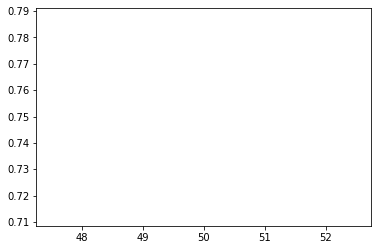

[ $$$ ] TEST


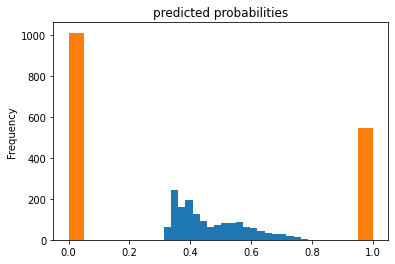

[ *** ] STEP MAX: 100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.789474
accuracy_baseline         0.568421
auc                       0.869241
auc_precision_recall      0.807420
average_loss              0.504754
label/mean                0.431579
loss                      0.770927
precision                 0.744186
prediction/mean           0.485976
recall                    0.780488
global_step             100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7883920505871725
[ $ ] VALIDATION ACCURACY OVER TIME: 


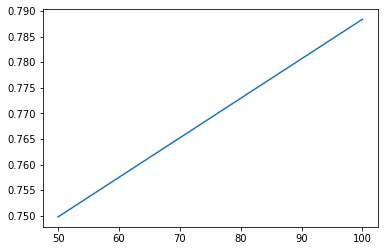

[ $$$ ] TEST


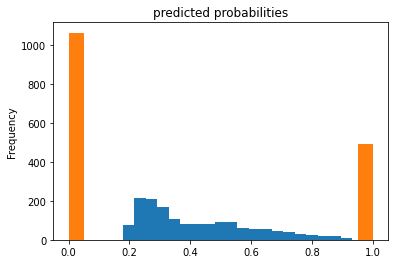

[ *** ] STEP MAX: 150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.825462
accuracy_baseline         0.548255
auc                       0.918837
auc_precision_recall      0.904052
average_loss              0.415657
label/mean                0.451745
loss                      0.650884
precision                 0.800000
prediction/mean           0.483376
recall                    0.818182
global_step             150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8248212461695608
[ $ ] VALIDATION ACCURACY OVER TIME: 


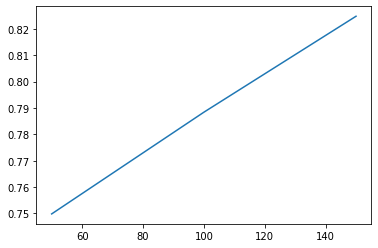

[ $$$ ] TEST


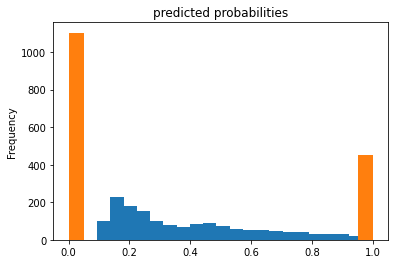

[ *** ] STEP MAX: 200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.774757
accuracy_baseline         0.504854
auc                       0.875302
auc_precision_recall      0.882787
average_loss              0.454565
label/mean                0.495146
loss                      0.752736
precision                 0.829384
prediction/mean           0.447737
recall                    0.686275
global_step             200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7739064856711915
[ $ ] VALIDATION ACCURACY OVER TIME: 


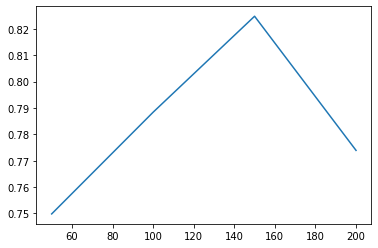

[ $$$ ] TEST


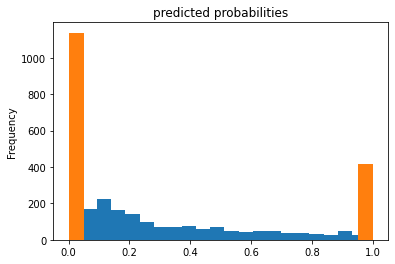

[ *** ] STEP MAX: 250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.782341
accuracy_baseline         0.548255
auc                       0.871255
auc_precision_recall      0.840167
average_loss              0.447762
label/mean                0.451745
loss                      0.701158
precision                 0.790816
prediction/mean           0.437771
recall                    0.704545
global_step             250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7754937010554988
[ $ ] VALIDATION ACCURACY OVER TIME: 


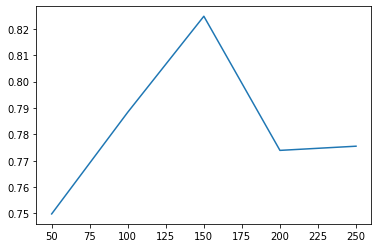

[ $$$ ] TEST


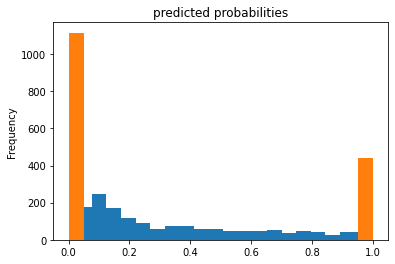

[ *** ] STEP MAX: 300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.802444
accuracy_baseline         0.541752
auc                       0.915246
auc_precision_recall      0.885756
average_loss              0.378930
label/mean                0.458248
loss                      0.598247
precision                 0.788288
prediction/mean           0.479752
recall                    0.777778
global_step             300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8005430242272349
[ $ ] VALIDATION ACCURACY OVER TIME: 


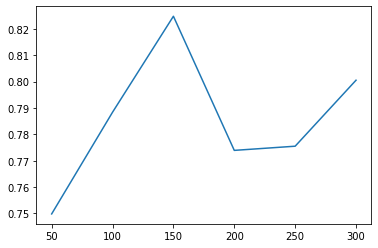

[ $$$ ] TEST


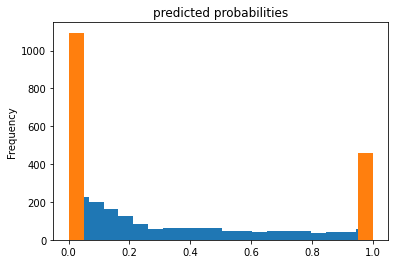

[ *** ] STEP MAX: 350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.821053
accuracy_baseline         0.568421
auc                       0.906323
auc_precision_recall      0.869104
average_loss              0.393219
label/mean                0.431579
loss                      0.600576
precision                 0.800000
prediction/mean           0.454185
recall                    0.780488
global_step             350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8161698283649503
[ $ ] VALIDATION ACCURACY OVER TIME: 


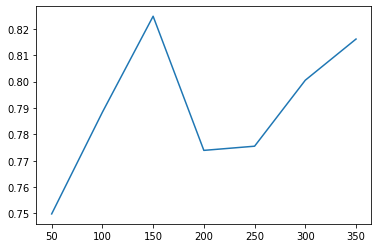

[ $$$ ] TEST


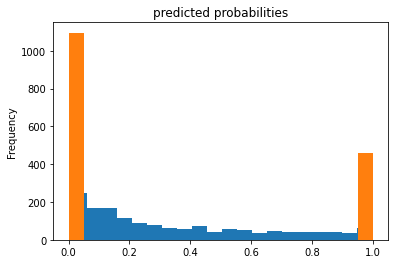

[ *** ] STEP MAX: 400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.854209
accuracy_baseline         0.548255
auc                       0.946161
auc_precision_recall      0.936176
average_loss              0.318366
label/mean                0.451745
loss                      0.498535
precision                 0.837104
prediction/mean           0.463438
recall                    0.840909
global_step             400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8530388151174667
[ $ ] VALIDATION ACCURACY OVER TIME: 


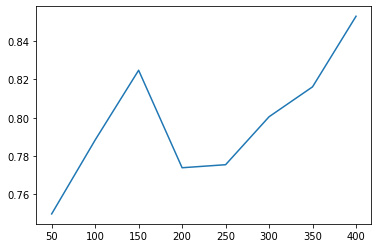

[ $$$ ] TEST


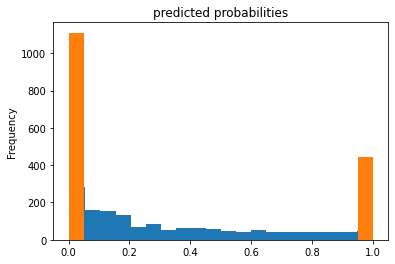

[ *** ] STEP MAX: 450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.772816
accuracy_baseline         0.504854
auc                       0.909691
auc_precision_recall      0.911780
average_loss              0.388584
label/mean                0.495146
loss                      0.643475
precision                 0.841584
prediction/mean           0.443445
recall                    0.666667
global_step             450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.7717948717948717
[ $ ] VALIDATION ACCURACY OVER TIME: 


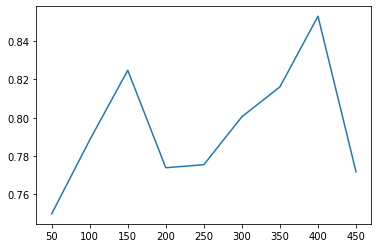

[ $$$ ] TEST


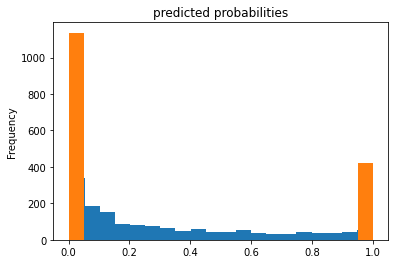

[ *** ] STEP MAX: 500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.811088
accuracy_baseline         0.548255
auc                       0.910240
auc_precision_recall      0.889325
average_loss              0.376536
label/mean                0.451745
loss                      0.589623
precision                 0.816832
prediction/mean           0.432116
recall                    0.750000
global_step             500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8057116104868914
[ $ ] VALIDATION ACCURACY OVER TIME: 


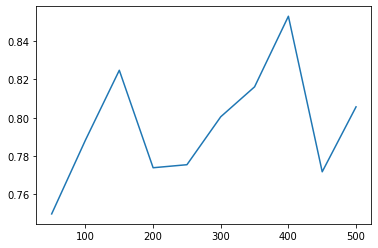

[ $$$ ] TEST


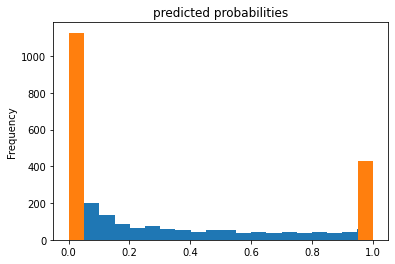

[ *** ] STEP MAX: 550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.865580
accuracy_baseline         0.541752
auc                       0.952089
auc_precision_recall      0.921617
average_loss              0.297921
label/mean                0.458248
loss                      0.470351
precision                 0.829876
prediction/mean           0.486690
recall                    0.888889
global_step             550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8673767752715121
[ $ ] VALIDATION ACCURACY OVER TIME: 


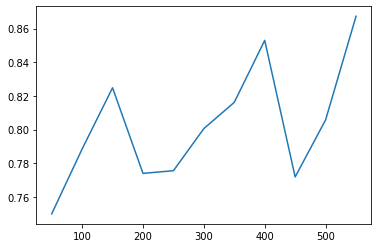

[ $$$ ] TEST


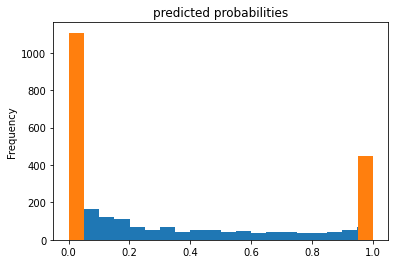

[ *** ] STEP MAX: 600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.831579
accuracy_baseline         0.568421
auc                       0.922132
auc_precision_recall      0.896434
average_loss              0.352582
label/mean                0.431579
loss                      0.538509
precision                 0.820513
prediction/mean           0.436791
recall                    0.780488
global_step             600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8254290876242096
[ $ ] VALIDATION ACCURACY OVER TIME: 


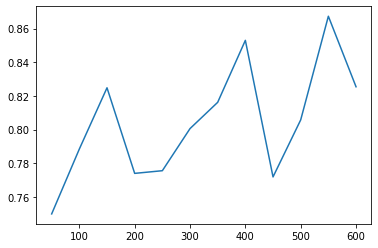

[ $$$ ] TEST


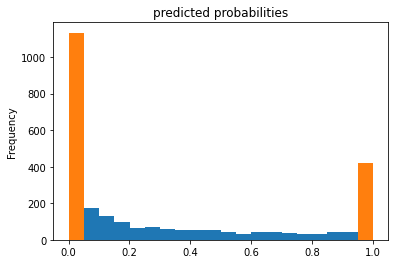

[ *** ] STEP MAX: 650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.852156
accuracy_baseline         0.548255
auc                       0.955737
auc_precision_recall      0.947785
average_loss              0.287679
label/mean                0.451745
loss                      0.450481
precision                 0.849057
prediction/mean           0.446537
recall                    0.818182
global_step             650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8491658154579503
[ $ ] VALIDATION ACCURACY OVER TIME: 


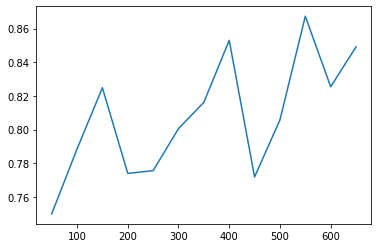

[ $$$ ] TEST


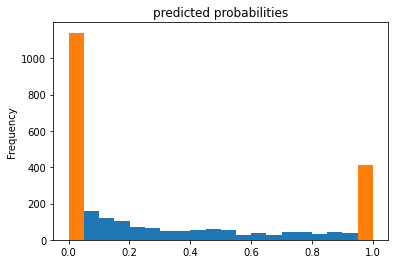

[ *** ] STEP MAX: 700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.809709
accuracy_baseline         0.504854
auc                       0.927564
auc_precision_recall      0.926413
average_loss              0.350678
label/mean                0.495146
loss                      0.580705
precision                 0.868545
prediction/mean           0.442108
recall                    0.725490
global_step             700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8088989441930619
[ $ ] VALIDATION ACCURACY OVER TIME: 


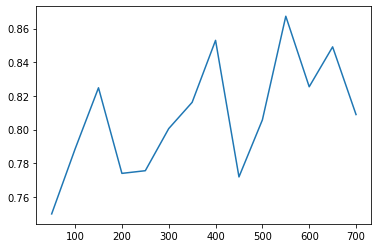

[ $$$ ] TEST


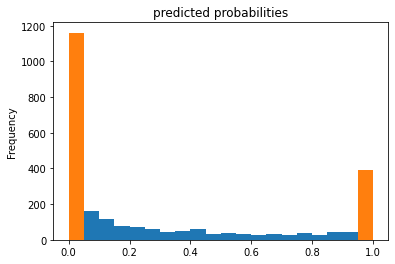

[ *** ] STEP MAX: 750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.841889
accuracy_baseline         0.548255
auc                       0.933521
auc_precision_recall      0.916069
average_loss              0.327778
label/mean                0.451745
loss                      0.513273
precision                 0.845411
prediction/mean           0.435555
recall                    0.795455
global_step             750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.837802179094314
[ $ ] VALIDATION ACCURACY OVER TIME: 


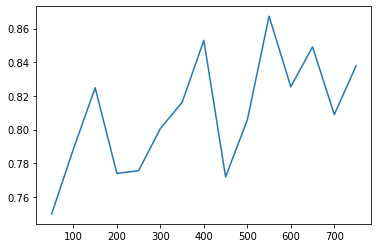

[ $$$ ] TEST


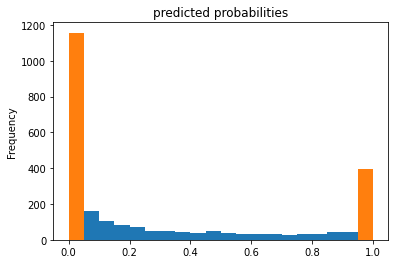

[ *** ] STEP MAX: 800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.906314
accuracy_baseline         0.541752
auc                       0.966750
auc_precision_recall      0.943461
average_loss              0.256337
label/mean                0.458248
loss                      0.404700
precision                 0.856574
prediction/mean           0.492200
recall                    0.955556
global_step             800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9101086048454471
[ $ ] VALIDATION ACCURACY OVER TIME: 


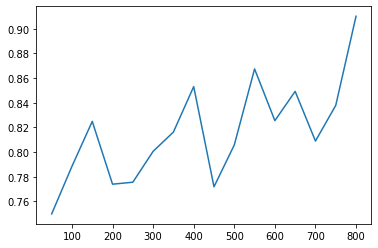

[ $$$ ] TEST


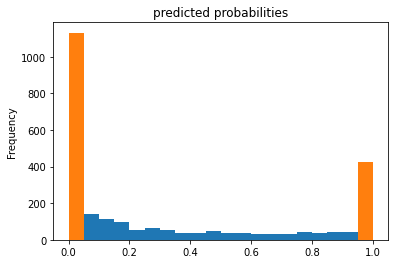

[ *** ] STEP MAX: 850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.844211
accuracy_baseline         0.568421
auc                       0.931346
auc_precision_recall      0.909471
average_loss              0.332223
label/mean                0.431579
loss                      0.507415
precision                 0.829146
prediction/mean           0.428421
recall                    0.804878
global_step             850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.839476061427281
[ $ ] VALIDATION ACCURACY OVER TIME: 


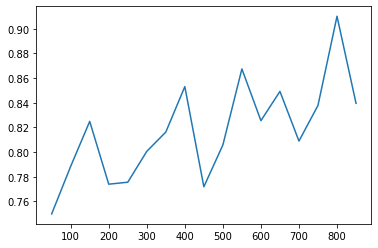

[ $$$ ] TEST


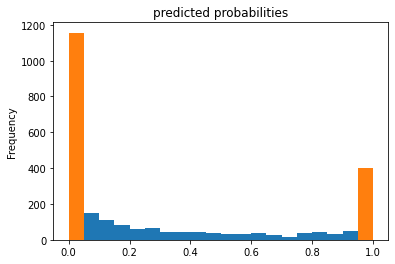

[ *** ] STEP MAX: 900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.870637
accuracy_baseline         0.548255
auc                       0.959142
auc_precision_recall      0.949431
average_loss              0.271053
label/mean                0.451745
loss                      0.424447
precision                 0.868545
prediction/mean           0.438596
recall                    0.840909
global_step             900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8680200885257066
[ $ ] VALIDATION ACCURACY OVER TIME: 


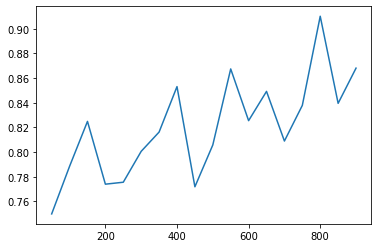

[ $$$ ] TEST


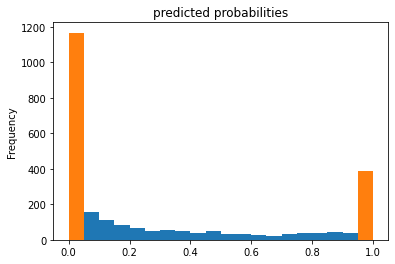

[ *** ] STEP MAX: 950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                  0.836893
accuracy_baseline         0.504854
auc                       0.939253
auc_precision_recall      0.936945
average_loss              0.329723
label/mean                0.495146
loss                      0.546004
precision                 0.890411
prediction/mean           0.438393
recall                    0.764706
global_step             950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8361990950226245
[ $ ] VALIDATION ACCURACY OVER TIME: 


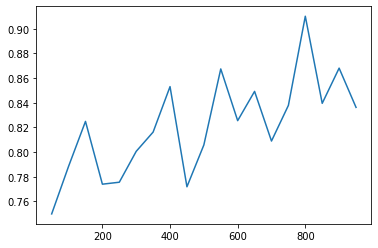

[ $$$ ] TEST


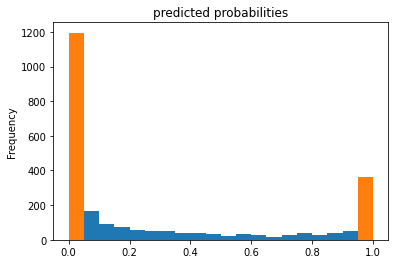

[ *** ] STEP MAX: 1000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.876797
accuracy_baseline          0.548255
auc                        0.944501
auc_precision_recall       0.926603
average_loss               0.297254
label/mean                 0.451745
loss                       0.465475
precision                  0.863636
prediction/mean            0.442118
recall                     0.863636
global_step             1000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8756384065372829
[ $ ] VALIDATION ACCURACY OVER TIME: 


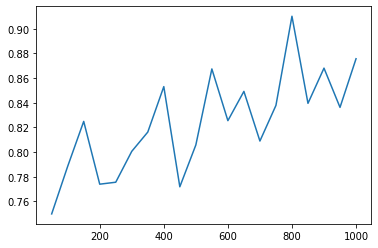

[ $$$ ] TEST


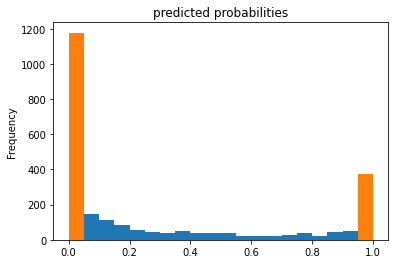

[ *** ] STEP MAX: 1050
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.924644
accuracy_baseline          0.541752
auc                        0.971763
auc_precision_recall       0.950715
average_loss               0.232674
label/mean                 0.458248
loss                       0.367340
precision                  0.873016
prediction/mean            0.493235
recall                     0.977778
global_step             1050.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9287385129490392
[ $ ] VALIDATION ACCURACY OVER TIME: 


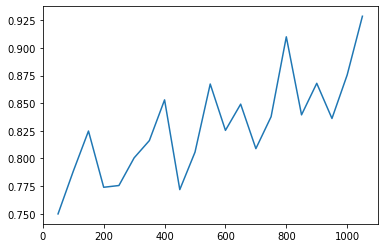

[ $$$ ] TEST


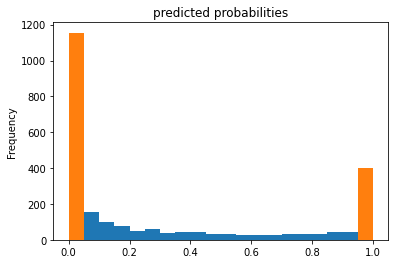

[ *** ] STEP MAX: 1100
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.858947
accuracy_baseline          0.568421
auc                        0.937127
auc_precision_recall       0.917012
average_loss               0.317285
label/mean                 0.431579
loss                       0.484600
precision                  0.841584
prediction/mean            0.424643
recall                     0.829268
global_step             1100.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8553748870822043
[ $ ] VALIDATION ACCURACY OVER TIME: 


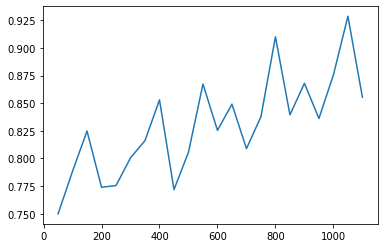

[ $$$ ] TEST


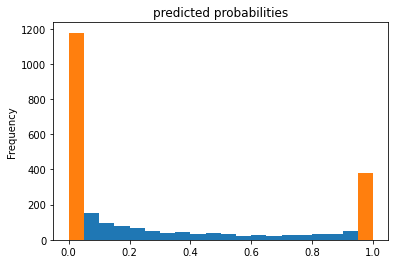

[ *** ] STEP MAX: 1150
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.876797
accuracy_baseline          0.548255
auc                        0.961525
auc_precision_recall       0.951537
average_loss               0.259584
label/mean                 0.451745
loss                       0.406487
precision                  0.880952
prediction/mean            0.430837
recall                     0.840909
global_step             1150.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8736380660537963
[ $ ] VALIDATION ACCURACY OVER TIME: 


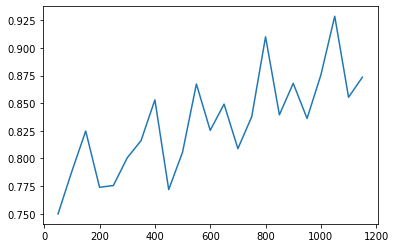

[ $$$ ] TEST


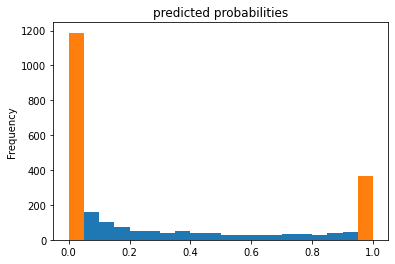

[ *** ] STEP MAX: 1200
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.838835
accuracy_baseline          0.504854
auc                        0.948680
auc_precision_recall       0.945668
average_loss               0.306710
label/mean                 0.495146
loss                       0.507896
precision                  0.894495
prediction/mean            0.438886
recall                     0.764706
global_step             1200.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8381221719457014
[ $ ] VALIDATION ACCURACY OVER TIME: 


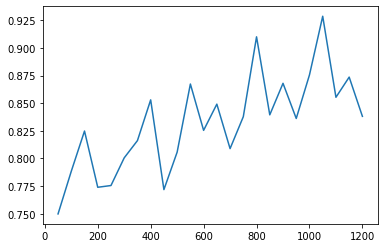

[ $$$ ] TEST


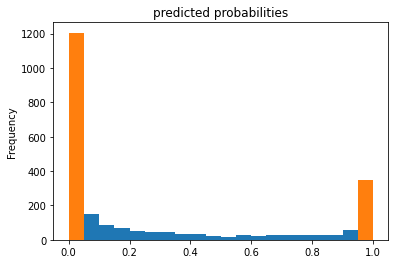

[ *** ] STEP MAX: 1250
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.891170
accuracy_baseline          0.548255
auc                        0.951992
auc_precision_recall       0.936801
average_loss               0.276884
label/mean                 0.451745
loss                       0.433578
precision                  0.874439
prediction/mean            0.447088
recall                     0.886364
global_step             1250.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8907473612529793
[ $ ] VALIDATION ACCURACY OVER TIME: 


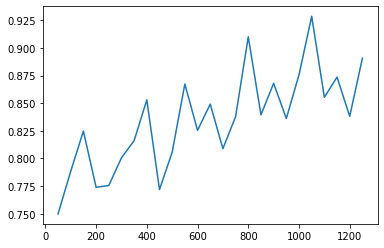

[ $$$ ] TEST


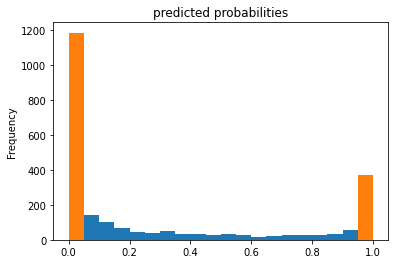

[ *** ] STEP MAX: 1300
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.928717
accuracy_baseline          0.541752
auc                        0.975815
auc_precision_recall       0.957426
average_loss               0.215021
label/mean                 0.458248
loss                       0.339470
precision                  0.880000
prediction/mean            0.490936
recall                     0.977778
global_step             1300.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9324979114452799
[ $ ] VALIDATION ACCURACY OVER TIME: 


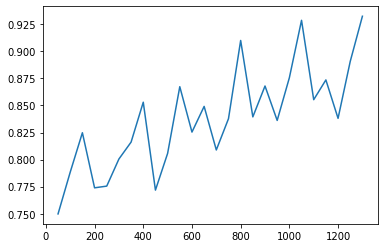

[ $$$ ] TEST


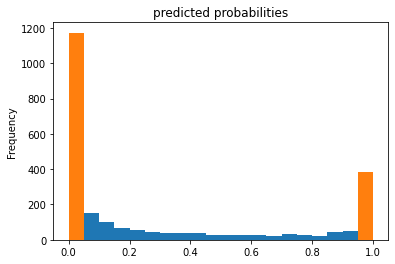

[ *** ] STEP MAX: 1350
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.869474
accuracy_baseline          0.568421
auc                        0.943902
auc_precision_recall       0.924532
average_loss               0.300112
label/mean                 0.431579
loss                       0.458371
precision                  0.862944
prediction/mean            0.421641
recall                     0.829268
global_step             1350.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8646341463414635
[ $ ] VALIDATION ACCURACY OVER TIME: 


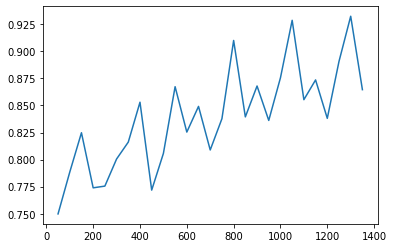

[ $$$ ] TEST


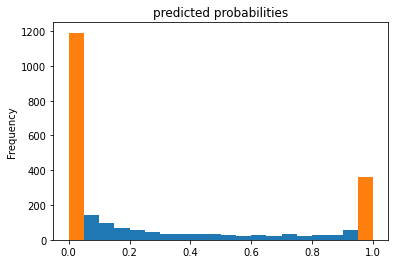

[ *** ] STEP MAX: 1400
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.885010
accuracy_baseline          0.548255
auc                        0.965994
auc_precision_recall       0.956045
average_loss               0.243648
label/mean                 0.451745
loss                       0.381532
precision                  0.879630
prediction/mean            0.431157
recall                     0.863636
global_step             1400.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8831290432414028
[ $ ] VALIDATION ACCURACY OVER TIME: 


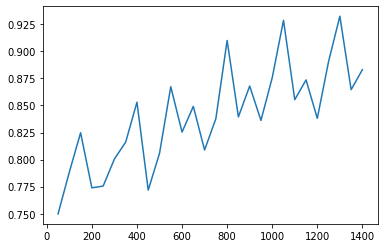

[ $$$ ] TEST


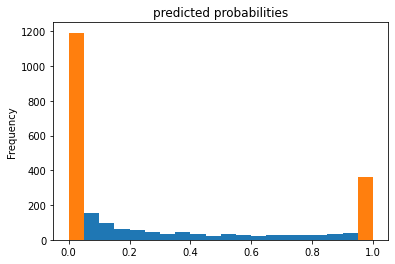

[ *** ] STEP MAX: 1450
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.848544
accuracy_baseline          0.504854
auc                        0.955468
auc_precision_recall       0.952147
average_loss               0.287579
label/mean                 0.495146
loss                       0.476215
precision                  0.915493
prediction/mean            0.438853
recall                     0.764706
global_step             1450.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8477375565610858
[ $ ] VALIDATION ACCURACY OVER TIME: 


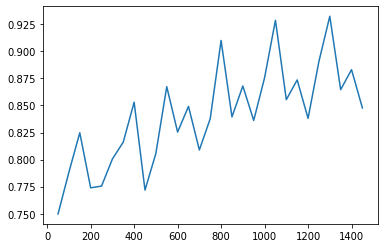

[ $$$ ] TEST


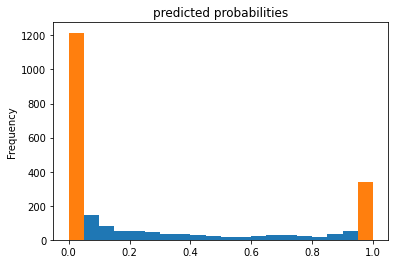

[ *** ] STEP MAX: 1500
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.893224
accuracy_baseline          0.548255
auc                        0.957099
auc_precision_recall       0.942265
average_loss               0.262690
label/mean                 0.451745
loss                       0.411351
precision                  0.878378
prediction/mean            0.448545
recall                     0.886364
global_step             1500.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8926200204290092
[ $ ] VALIDATION ACCURACY OVER TIME: 


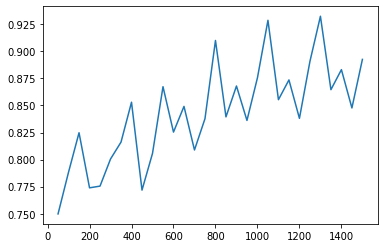

[ $$$ ] TEST


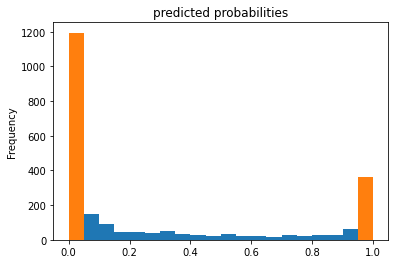

[ *** ] STEP MAX: 1550
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.936864
accuracy_baseline          0.541752
auc                        0.978070
auc_precision_recall       0.957081
average_loss               0.201172
label/mean                 0.458248
loss                       0.317607
precision                  0.894309
prediction/mean            0.491131
recall                     0.977778
global_step             1550.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.940016708437761
[ $ ] VALIDATION ACCURACY OVER TIME: 


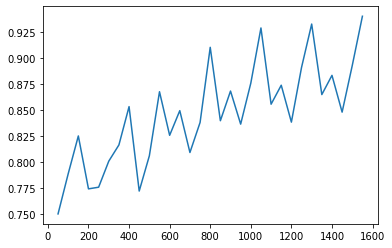

[ $$$ ] TEST


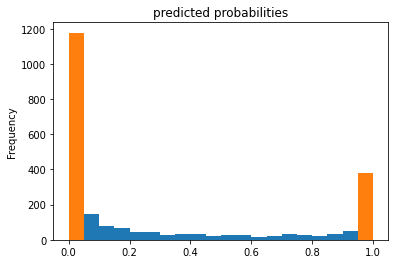

[ *** ] STEP MAX: 1600
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.871579
accuracy_baseline          0.568421
auc                        0.949548
auc_precision_recall       0.931506
average_loss               0.286880
label/mean                 0.431579
loss                       0.438161
precision                  0.867347
prediction/mean            0.420643
recall                     0.829268
global_step             1600.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8664859981933153
[ $ ] VALIDATION ACCURACY OVER TIME: 


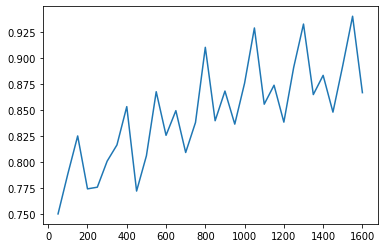

[ $$$ ] TEST


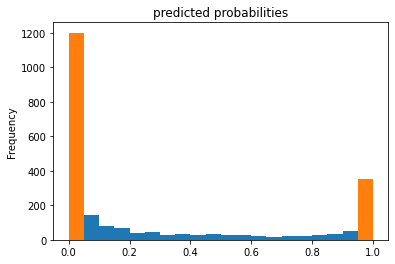

[ *** ] STEP MAX: 1650
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.905544
accuracy_baseline          0.548255
auc                        0.969442
auc_precision_recall       0.960430
average_loss               0.230401
label/mean                 0.451745
loss                       0.360789
precision                  0.884956
prediction/mean            0.428451
recall                     0.909091
global_step             1650.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9058563159686756
[ $ ] VALIDATION ACCURACY OVER TIME: 


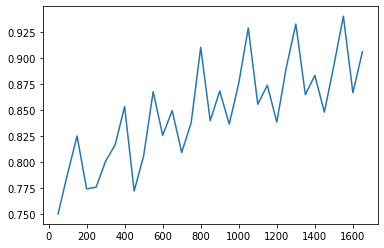

[ $$$ ] TEST


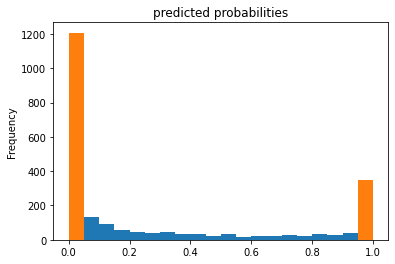

[ *** ] STEP MAX: 1700
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.854369
accuracy_baseline          0.504854
auc                        0.962330
auc_precision_recall       0.959748
average_loss               0.266527
label/mean                 0.495146
loss                       0.441355
precision                  0.909091
prediction/mean            0.441236
recall                     0.784314
global_step             1700.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8536953242835595
[ $ ] VALIDATION ACCURACY OVER TIME: 


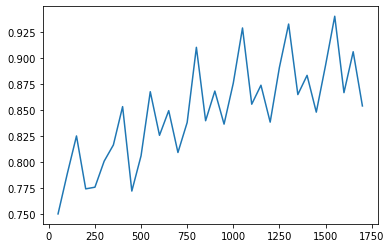

[ $$$ ] TEST


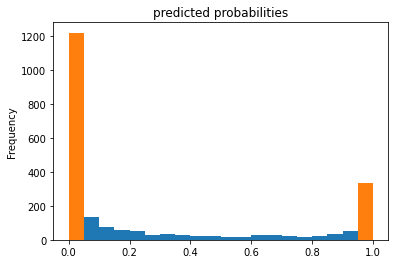

[ *** ] STEP MAX: 1750
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.891170
accuracy_baseline          0.548255
auc                        0.959440
auc_precision_recall       0.945325
average_loss               0.251152
label/mean                 0.451745
loss                       0.393283
precision                  0.874439
prediction/mean            0.448846
recall                     0.886364
global_step             1750.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8907473612529793
[ $ ] VALIDATION ACCURACY OVER TIME: 


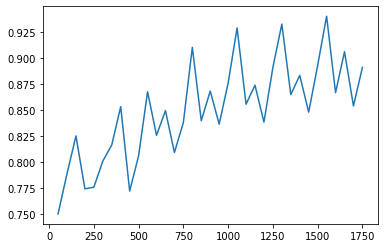

[ $$$ ] TEST


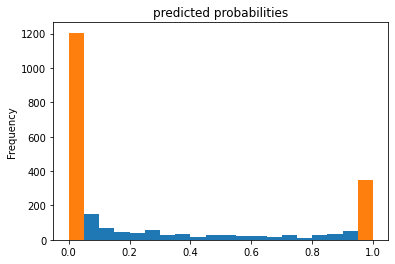

[ *** ] STEP MAX: 1800
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.934827
accuracy_baseline          0.541752
auc                        0.980284
auc_precision_recall       0.960688
average_loss               0.189306
label/mean                 0.458248
loss                       0.298872
precision                  0.890688
prediction/mean            0.489169
recall                     0.977778
global_step             1800.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9381370091896408
[ $ ] VALIDATION ACCURACY OVER TIME: 


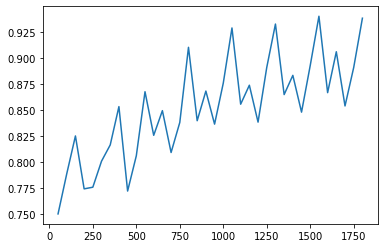

[ $$$ ] TEST


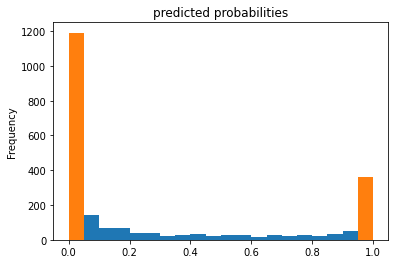

[ *** ] STEP MAX: 1850
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.886316
accuracy_baseline          0.568421
auc                        0.953839
auc_precision_recall       0.936648
average_loss               0.276177
label/mean                 0.431579
loss                       0.421814
precision                  0.879397
prediction/mean            0.419237
recall                     0.853659
global_step             1850.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8823848238482386
[ $ ] VALIDATION ACCURACY OVER TIME: 


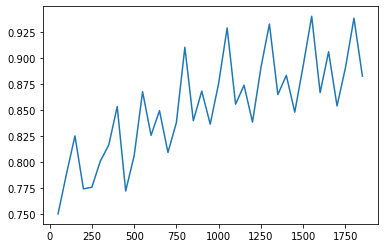

[ $$$ ] TEST


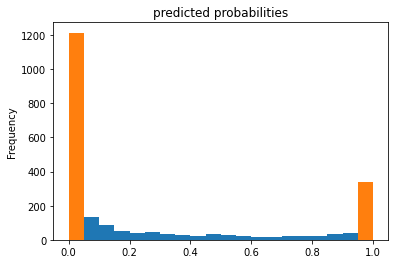

[ *** ] STEP MAX: 1900
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.909651
accuracy_baseline          0.548255
auc                        0.971485
auc_precision_recall       0.963031
average_loss               0.219769
label/mean                 0.451745
loss                       0.344139
precision                  0.892857
prediction/mean            0.429771
recall                     0.909091
global_step             1900.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.9096016343207355
[ $ ] VALIDATION ACCURACY OVER TIME: 


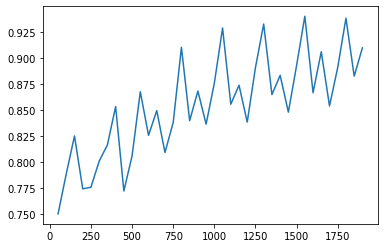

[ $$$ ] TEST


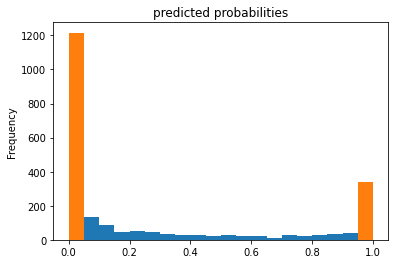

[ *** ] STEP MAX: 1950
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.869903
accuracy_baseline          0.504854
auc                        0.967308
auc_precision_recall       0.965842
average_loss               0.248198
label/mean                 0.495146
loss                       0.411003
precision                  0.923423
prediction/mean            0.443878
recall                     0.803922
global_step             1950.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8692684766214177
[ $ ] VALIDATION ACCURACY OVER TIME: 


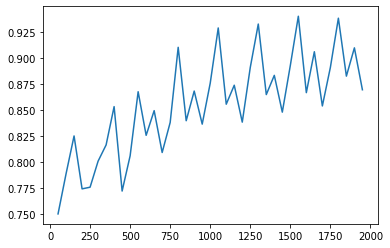

[ $$$ ] TEST


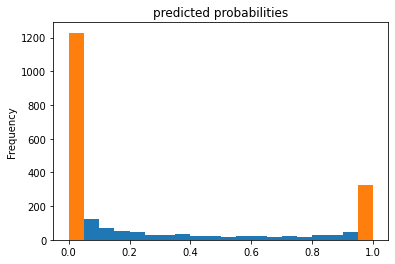

[ *** ] STEP MAX: 2000
[ $$$ ] TRAINING
[ $$$ ] EVAL RESULTS:
accuracy                   0.893224
accuracy_baseline          0.548255
auc                        0.962632
auc_precision_recall       0.950080
average_loss               0.242456
label/mean                 0.451745
loss                       0.379666
precision                  0.878378
prediction/mean            0.449108
recall                     0.886364
global_step             2000.000000
dtype: float64
[ $ ] WEIGHTED ACCURACY ON EVAL: 
0.8926200204290092
[ $ ] VALIDATION ACCURACY OVER TIME: 


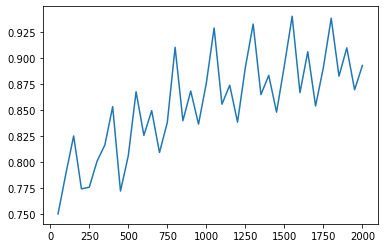

[ $$$ ] TEST


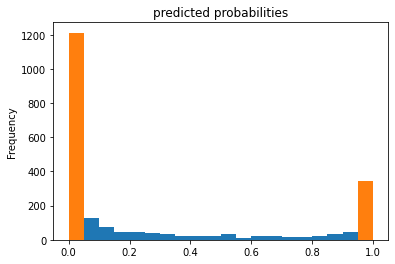

[ *** ] STEP MAX: 2050
[ $$$ ] TRAINING


KeyboardInterrupt: 

In [18]:
# CREATIVE MODEL

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))
DNN_NUMERIC_COLUMNS = []
DNN_NUMERIC_COLUMNS = ['neigh_vote', 'neigh_swing', 'neigh_pop']
dnn_feature_cols = feature_columns

# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

# Training and evaluation input functions.
og_train_input_fn = make_input_fn(train_x, train_y, shuffle=False, n_epochs=1)
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
test_input_fn = make_input_fn(test_x, None, shuffle=False, n_epochs=1)

# (k-1)/k size MINI BATCHING
trains = []
vals = []
k = 5
splitter = 1555//k
split_index = [splitter*i for i in range(k)]
back_idx = [splitter*(i+1) for i in range(k)]
back_idx[-1] = 1555
yvals = []

train_x1 = train_x
train_y1 = train_y

for i in range(k):
    train_x = train_x1.copy()
    train_y = train_y1.copy()
    tdf = pd.concat([train_x.iloc[:split_index[i],:], train_x.iloc[back_idx[i]:,:]])
    ty = pd.concat([train_y.iloc[:split_index[i]], train_y.iloc[back_idx[i]:]])
    
    df = train_x.iloc[split_index[i]:back_idx[i],:]
    y = train_y.iloc[split_index[i]:back_idx[i]]
    
    trains.append(make_input_fn(tdf, ty, shuffle = True))
    vals.append(make_input_fn(df,y,shuffle=False, n_epochs=1))
    yvals.append(y)

'''
Since data fits into memory, use entire dataset per layer. It will be faster.
Above one batch is defined as the entire dataset.
'''

weight_col = 'Weight'

# DNN??
est = tf.estimator.DNNLinearCombinedClassifier(
    # wide settings
    linear_feature_columns=feature_columns,
    linear_optimizer = 'Adam',
    dnn_optimizer = 'Adam',
    dnn_feature_columns=feature_columns,  
    dnn_activation_fn = tf.nn.relu,
    dnn_hidden_units=[15],
    weight_column = 'Weight',
    dnn_dropout = None,
    batch_norm = False
)

_run = True
n = 0
i = 3
scores = [0 for i in range(k)]

accs = []
ns = []

while _run:
    incr = 50
    n += incr
    
    # EARLY STOPPING
    if n > 100*incr:
        break
    
    # BATCH SELECTOR
    i += 1
    i = i%k
    
    print(f"[ *** ] STEP MAX: {n}")
    
    # Train on mini batches    
    train_input_fn = trains[i]
    eval_input_fn  = vals[i]

    print("[ $$$ ] TRAINING")
    # Train up to n steps
    est.train(train_input_fn, max_steps=n)
    
    # Eval.
    print("[ $$$ ] EVAL RESULTS:")
    eval_pred_dicts = list(est.predict(eval_input_fn))
    result = est.evaluate(eval_input_fn)
    print(pd.Series(result))

    eval_preds = pd.Series([pred['probabilities'][1] for pred in eval_pred_dicts])
    
    eval_submission = cthresh(eval_preds, thresh = 0.5)
    w_acc = weighted_accuracy(eval_submission, yvals[i])
    accs.append(w_acc)
        
    scores[i] = w_acc
    print("[ $ ] WEIGHTED ACCURACY ON EVAL: ")
    print(w_acc)
    
    # Create a graph over time of 1/k validation accuracy
    print("[ $ ] VALIDATION ACCURACY OVER TIME: ")
    ns.append(n)
    plt.plot(ns,accs)
    plt.show()
    
    # Test and send to submission
    print("[ $$$ ] TEST")
    pred_dicts = list(est.predict(test_input_fn))
    
    preds = None
    preds = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

    # Create histogram of the predictions
    preds.plot(kind='hist', bins=20, title='predicted probabilities')

    submission = cpackage(preds, dfsample.copy(), thresh = 0.5)
    
    # Create a histogram of submission statistics
    submission.iloc[0:,1].plot(kind='hist', bins=20, title='predicted probabilities')
    plt.show()
 
    name = 'creative/submission2_r.csv'
    submission.to_csv(name ,index = False)
    submiss = pd.read_csv(name, sep=',', encoding='unicode_escape')

    _run = w_acc < 1.01

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [ ]:
# TODO

# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.

<h2>Part 5: Resources and Literature Used</h2><p>